<a href="https://colab.research.google.com/github/mitsukacke2285/drug_discovery_repo/blob/main/Ligand_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ligand preparation

# Step 1: Installation of dependencies

Please install the following packages:
* `PDBFixer`
* `Biopython`
* `MDAnalysis`
* `RDKit`
* `OpenMM` (and `OpenMMForceFields`)
* `OpenBabel`
* `Scrubber` (package: "`molscrub`")
* `py3Dmol`

In [ ]:
!pip install rdkit openmm mdanalysis molscrub py3dmol biopython
!pip install pdbfixer

In [ ]:
!pip install molscrub

In [ ]:
# Run this cell if pdbfixer could not be installed on colab
!pip install git+https://github.com/openmm/pdbfixer.git

  Cloning https://github.com/openmm/pdbfixer.git to c:\users\pham.congdat\appdata\local\temp\pip-req-build-hr_jp4q7
  Resolved https://github.com/openmm/pdbfixer.git to commit 0f701349b1d0b7c91d2ca0db78359274d0793400
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/openmm/pdbfixer.git 'C:\Users\pham.congdat\AppData\Local\Temp\pip-req-build-hr_jp4q7'


If running on colab, upload the following file:

In [ ]:
# If using google colab please upload the following files: test1.csv and {pdb_id}_A.pdb
from google.colab import files

# Upload a {pdb_id}.pdb file from local PC to your Colab VM
files.upload("molecular_docking/protein_files")

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
# Upload a csv file containing multiple SMILES from local PC to your Colab VM
files.upload("molecular_docking/ligand_structures")

Saving test2.csv to molecular_docking/ligand_structures/test2.csv


{'molecular_docking/ligand_structures/test2.csv': b'SMILES\r\nO=C(C1=CC=C(C=C1)C2=CC=CC=C2)O[C@@H]3C[NH2+][C@@H](C3)C([O-])=O\r\nN[C@@H](C(O)=O)CCN(CC1=C(OCC2=CC=CC(C)=C2)C=CC=C1)CC3=C(OCC4=CC=CC(C)=C4)C=CC=C3\r\nN[C@@H](C(O)=O)CCN1CC(C(OCC2=CC(C)=CC=C2)=CC=C3)=C3C(C=CC=C4OCC5=CC(C)=CC=C5)=C4C1\r\nN[C@H](CCN1CC2=C(C3=C(C1)C(OC)=CC=C3)C=CC=C2OC)C(O)=O\r\n'}

# Step 2 Building Atomistic Ligand Model

## Step 2.1 Set protein ID

In [ ]:
import os
import requests

pdb_id = input("Enter PDB code: ") # The Protein ID we're looking at

# Start by making a directory for us to work in and stage our intermediate files
protein_directory = "molecular_docking/protein_files"
protein_filename = f"{pdb_id}_A.pdb"
protein_filepath = os.path.join(protein_directory, protein_filename)

# Actually make the directory, the exist_ok flag lets the command execute even if the folder already exists. It does NOT overwrite existing data.
os.makedirs(protein_directory, exist_ok=True)

print(protein_filepath)

Enter PDB code:  7BCS


molecular_docking/protein_files\7BCS_A.pdb


## Step 2.2 Determine residues nearby the ligand with MDAnalysis

In [ ]:
import MDAnalysis as mda

# Load the original PDB
u = mda.Universe(f"{protein_directory}/{pdb_id}_A.pdb")

# Select atoms using the MDAnalysis selection language
ligand_select = "segid A and record_type HETATM and not resname HOH"
ligand = u.select_atoms(ligand_select)

# Find and residues within a certain distance from the ligand
active_site = u.select_atoms(f"around 3.5 group ligand and segid A",
                             periodic=False,
                             ligand=ligand)  # Uses generic select_name=object as kwargs
print(active_site.residues.resids)
print(ligand.residues.resids)

[104 231 352 353 354 357 383 384 387 429 431 432 464 467 468 471]
[601]


## Step 2.3 Select ligand bound in PDB structure

In [ ]:
import numpy as np

ligands = u.select_atoms("not protein and not water")
i = -1 # index
ligand_residue_names = ligands.residues.resnames

# Loop through all ligands present and prints out their code
for lig in ligand_residue_names:
  i = i+1
  print(i, lig)

# Select the index of your ligand of interest
ligand_id = np.unique(ligand_residue_names)[int(input('Enter index of ligand of interest: '))]
print(f"You have selected {ligand_id} as your ligand.")

0 TJ5


Enter index of ligand of interest:  0


You have selected TJ5 as your ligand.


## Step 2.4 Download the ideal ligand from the RCSB

In [ ]:
# The following cell executes the code for downloading the ideal ligand,
# i.e. the co-crystallized ligand extracted from the PDB structure.
# An ideal ligand is needed:
# 1. align the pose of the extracted ligand with ideal ligand
# 2. obtain the correct 3D coordinates for generating the docking grid box

ligand_directory = "molecular_docking/ligand_structures"
os.makedirs(ligand_directory, exist_ok=True)

ideal_ligand_filename = f"{ligand_id}_ideal.sdf"
print(f"Downloading ligand {ligand_id}...")
ligand_url = f"https://files.rcsb.org/ligands/download/{ideal_ligand_filename}"
ligand_request = requests.get(ligand_url)
ligand_request.raise_for_status() # Check for errors

ideal_filepath = f"{ligand_directory}/{ideal_ligand_filename}"

with open(ideal_filepath, "w") as f:
    f.write(ligand_request.text)
print(f"Saved ligand to {ideal_filepath}")

Saved ligand to molecular_docking/ligand_structures/TJ5_ideal.sdf


```
The following cell executes the code for downloading the ideal ligand, i.e. the co-crystallized ligand extracted from the PDB structure. An ideal ligand is needed:
    1. to align the pose of the extracted ligand with ideal ligand
    2. to obtain the correct 3D coordinates for generating the docking grid box
    The ideal ligand file can be found on https://www.rcsb.org/. Search for the desired PDB and scroll down to "small molecule" section, left-click on scroll-down menu "Download instance coordinates", select the option with [auth A].
    For example, for the PDB id 7BCS the ideal ligand can be downloaded  at https://models.rcsb.org/v1/7bcs/ligand?auth_seq_id=601&label_asym_id=D&encoding=sdf&filename=7bcs_D_TJ5.sdf

    Please rename the file to {ligand_id}_ideal.sdf, e.g. 7bcs_D_TJ5.sdf ===> TJ5_ideal.sdf
```

In [ ]:
# Run in colab only
ligand_directory = "molecular_docking/ligand_structures"
os.makedirs(ligand_directory, exist_ok=True)

# Upload  from local PC to your Colab VM
files.upload("molecular_docking/ligand_structures")

NameError: name 'files' is not defined

In [ ]:
ligand_directory = "molecular_docking/ligand_structures"
os.makedirs(ligand_directory, exist_ok=True)

## Step 2.5 Split the ligand out into its own PDB file from the experimental one

In [ ]:
# Split the ligand out into its own PDB file from the experimental one
single_pose_ligand = ligand.select_atoms("segid A")
single_pose_ligand.write(f"{ligand_directory}/{ligand_id}_fromPDB.pdb")

# Step 3 Ligand preparation - Extracted ligand

## Step 3.1 Rdkit - Partial preparation and correcting the pose of extracted ligand

In [ ]:
# The following cell executes the code to partially prepare and correct the 3D orientation (pose) of the extracted ligand,
# and save it as {ligand_id}_corrected_pose.sdf which will be later used to generate a grid box for docking.

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.EnumerateStereoisomers import EnumerateStereoisomers, StereoEnumerationOptions

# Load and remove the hydrogens that we can't map anyways yet.
ideal_mol = Chem.MolFromMolFile(f"{ligand_directory}/{ligand_id}_ideal.sdf", removeHs=True)
pose_mol = Chem.MolFromPDBFile(f"{ligand_directory}/{ligand_id}_fromPDB.pdb", removeHs=True)

# Disconnect any organometal
rdMolStandardize.DisconnectOrganometallicsInPlace(pose_mol)

# Remove disconnected fragments
fragmenter = rdMolStandardize.FragmentRemover()
pose_mol_f = fragmenter.remove(pose_mol)

# Choose largest fragment
chooser = rdMolStandardize.LargestFragmentChooser()
pose_mol_lf = chooser.choose(pose_mol_f)

# Set options: include tetrahedral and double bond stereoisomers
options = StereoEnumerationOptions(tryEmbedding=True, onlyUnassigned=False)

# Assign bond orders from the template to the pose molecule
corrected_pose = AllChem.AssignBondOrdersFromTemplate(ideal_mol, pose_mol_lf)

# Add hydrogens
corrected_pose_with_H = Chem.AddHs(corrected_pose, addCoords=True)

# Sanity to check to make sure the molecule is right (check smiles of both)
assert Chem.MolToSmiles(corrected_pose) == Chem.MolToSmiles(ideal_mol)

# Save the corrected pose to an SDF file
ligand_corrected_pose_file = f"{ligand_directory}/{ligand_id}_corrected_pose.sdf"
writer = Chem.SDWriter(ligand_corrected_pose_file)
writer.write(corrected_pose_with_H)
writer.close()

[16:47:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[16:47:50] Initializing MetalDisconnector
[16:47:50] Running MetalDisconnector
[16:47:50] Running FragmentRemover
[16:47:50] Running LargestFragmentChooser
[16:47:50] WARNING: More than one matching pattern found - picking one



In [ ]:
# Comparison of SMILES of prepared extracted ligand with ideal ligand
print(Chem.MolToSmiles(corrected_pose))
print(Chem.MolToSmiles(pose_mol_lf))
print(Chem.MolToSmiles(ideal_mol))

O=C(O[C@@H]1CN[C@H](C(=O)O)C1)c1ccc(-c2ccccc2)cc1
OC(O[C@@H]1CN[C@H](C(O)O)C1)C1CCC(C2CCCCC2)CC1
O=C(O[C@@H]1CN[C@H](C(=O)O)C1)c1ccc(-c2ccccc2)cc1


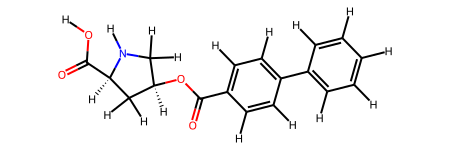

In [ ]:
# Check our molecule from RDKit. Doesn't have rotation, but its neat to see in a Jupyter Notebook for just invoking it
from rdkit.Chem import AllChem, Draw

AllChem.Compute2DCoords(corrected_pose_with_H)
Draw.MolToImage(corrected_pose_with_H)

corrected_pose_with_H

In [ ]:
# Check results
print("Corrected pose SMILES:", Chem.MolToSmiles(corrected_pose_with_H))

supp = Chem.SDMolSupplier(f"{ligand_directory}/{ligand_id}_corrected_pose.sdf")

for mol in supp:
    if mol is not None:
        print("Corrected mols: ", Chem.MolToSmiles(mol))

print("Ideal mol SMILES:", Chem.MolToSmiles(ideal_mol))

u.select_atoms("segid A")

Corrected pose SMILES: [H]OC(=O)[C@@]1([H])N([H])C([H])([H])[C@@]([H])(OC(=O)c2c([H])c([H])c(-c3c([H])c([H])c([H])c([H])c3[H])c([H])c2[H])C1([H])[H]
Corrected mols:  O=C(O[C@@H]1CN[C@H](C(=O)O)C1)c1ccc(-c2ccccc2)cc1
Ideal mol SMILES: O=C(O[C@@H]1CN[C@H](C(=O)O)C1)c1ccc(-c2ccccc2)cc1


<AtomGroup with 6720 atoms>

## Step 3.2 Creating tautomers (optional)

In [ ]:
from rdkit.Chem.MolStandardize import rdMolStandardize
# Initialize enumerator
tautomer_enumerator = rdMolStandardize.TautomerEnumerator()
# Provide RDKit Mol object to generate.
# We already made this, but you may start from a SMILE string or other source
# Remember, use the structure with implicit hydrogens!
tautomers = tautomer_enumerator.Enumerate(corrected_pose)
# Take the TautomerEnumerationResults object and iterate over to get a list of structures
tautomers_list = [t for t in tautomers]

'''
Note! This may generate duplicate structures,
You may want to cast these Mol objects into SMILES strings, de-duplicate,
then rebuild the Mol objects to map their coordinates back onto the reference structure
'''

# Cast to a set to make unique, then back to a list (as some tautomers can be enumerated again for some structures)
smiles_set_tautomers = set(Chem.MolToSmiles(t) for t in tautomers_list)
tautomer_list_unique = list(smiles_set_tautomers)
# We know the ligand structure does have unique tautomers, this is just a sanity check
assert len(tautomers_list) == len(tautomer_list_unique)

In [ ]:
ligand_tautomers = f"{ligand_directory}/{ligand_id}_tautomers.sdf"
writer = Chem.SDWriter(ligand_tautomers)
for t in tautomers_list:
  writer.write(t)
writer.close()

In [ ]:
for t in tautomer_list_unique:
  print(t)

O=C(O[C@@H]1CNC(C(=O)O)C1)c1ccc(-c2ccccc2)cc1
O=C(O[C@@H]1CNC(=C(O)O)C1)c1ccc(-c2ccccc2)cc1


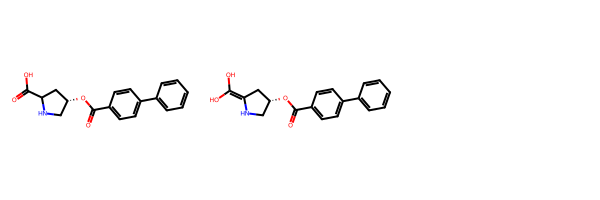

In [ ]:
from rdkit.Chem import Draw
Draw.MolsToGridImage([Chem.MolFromSmiles(t) for t in tautomer_list_unique])

## Step 3.3 Execute Scrubber to prepare extracted ligand

In [ ]:
from rdkit import Chem
from scrubber import Scrub

cmd = f"""scrub.py {ligand_directory}/{ligand_id}_corrected_pose.sdf -o {ligand_directory}/{ligand_id}.sdf"""

!{cmd}

# Create our PDBQT to keep our hydrogens
ligand_pdbqt_filename = f"{ligand_directory}/{ligand_id}.pdbqt"
os.system(f"obabel {ligand_corrected_pose_file} -O {ligand_pdbqt_filename} -xh")

Scrub completed.
Summary of what happened:
Input molecules supplied: 1
mols processed: 1, skipped by rdkit: 0, failed: 0
nr isomers (tautomers and acid/base conjugates): 1 (avg. 1.000 per mol)
nr conformers:  1 (avg. 1.000 per isomer, 1.000 per mol)


0

In [ ]:
# When using colab run this cell instead
from rdkit import Chem
from molscrub import Scrub

cmd = f"""scrub.py {ligand_directory}/{ligand_id}_corrected_pose.sdf -o {ligand_directory}/{ligand_id}.sdf"""

!{cmd}

# Create our PDBQT to keep our hydrogens
ligand_pdbqt_filename = f"{ligand_directory}/{ligand_id}.pdbqt"
os.system(f"obabel {ligand_corrected_pose_file} -O {ligand_pdbqt_filename} -xh")

ModuleNotFoundError: No module named 'molscrub'

In [ ]:
# Check results
print("Corrected pose SMILES:", Chem.MolToSmiles(corrected_pose_with_H))

supp = Chem.SDMolSupplier(f"{ligand_directory}/{ligand_id}.sdf")
i = 0

for mol in supp:
    if mol is not None:
        i += 1
        print(f"Tautomer mol {i}: ", Chem.MolToSmiles(mol))

print("Ideal mol smile:", Chem.MolToSmiles(ideal_mol))

u.select_atoms("segid A")

Corrected pose SMILES: [H]OC(=O)[C@@]1([H])N([H])C([H])([H])[C@@]([H])(OC(=O)c2c([H])c([H])c(-c3c([H])c([H])c([H])c([H])c3[H])c([H])c2[H])C1([H])[H]
Tautomer mol 1:  O=C(O[C@@H]1C[NH2+][C@H](C(=O)[O-])C1)c1ccc(-c2ccccc2)cc1
Ideal mol smile: O=C(O[C@@H]1CN[C@H](C(=O)O)C1)c1ccc(-c2ccccc2)cc1


<AtomGroup with 6720 atoms>

In [ ]:
# Voila! The ligand is ready for docking!

# Step 4 Ligand preparation - multiple ligands

## Step 4.1 Load the SMILES strings into RDKit and write back out an SDF file

In [ ]:
# Default delimiter is tab (\t), so we need to specify ","
smiles_supplier = Chem.SmilesMolSupplier(f"{ligand_directory}/test2.csv", delimiter=",")
mols = []  # Could do this in list comprehension, adding a sanity check
for mol in smiles_supplier:
  print(Chem.MolToSmiles(mol))  # Sanity check that we got the smiles strings and not metadata
  mols.append(mol)

# Write out our molecules
ligands_to_dock_dirty = f"{ligand_directory}/ligands_to_dock_dirty.sdf"
writer = Chem.SDWriter(ligands_to_dock_dirty)
for m in mols:
  writer.write(m)
writer.close()

O=C(O[C@@H]1C[NH2+][C@H](C(=O)[O-])C1)c1ccc(-c2ccccc2)cc1
Cc1cccc(COc2ccccc2CN(CC[C@@H](N)C(=O)O)Cc2ccccc2OCc2cccc(C)c2)c1
Cc1cccc(COc2cccc3c2CN(CC[C@@H](N)C(=O)O)Cc2c(OCc4cccc(C)c4)cccc2-3)c1
COc1cccc2c1CN(CC[C@@H](N)C(=O)O)Cc1c(OC)cccc1-2


[16:42:58] WARNING: no name column found on line 1
[16:42:58] WARNING: no name column found on line 2
[16:42:58] WARNING: no name column found on line 3
[16:42:58] WARNING: no name column found on line 4


## Step 4.2 Execute Scrubber to prepare multiple ligands

In [ ]:
cmd = f"""scrub.py {ligand_directory}/ligands_to_dock_dirty.sdf -o {ligand_directory}/ligands_to_dock.sdf"""

!{cmd}

Scrub completed.
Summary of what happened:
Input molecules supplied: 4
mols processed: 4, skipped by rdkit: 0, failed: 0
nr isomers (tautomers and acid/base conjugates): 4 (avg. 1.000 per mol)
nr conformers:  4 (avg. 1.000 per isomer, 1.000 per mol)


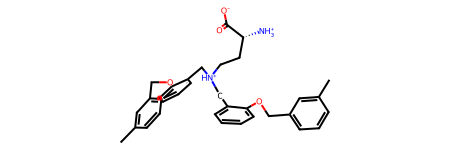

In [ ]:
# Sanity check we got a structure with hydrogens
# RDKit automatically removes hydrogens by default (needed for most of the kit to work)
# But we're explicitly looking for them here, we can just load them and check
supplier = Chem.SDMolSupplier(f"{ligand_directory}/ligands_to_dock.sdf", removeHs=True)
reloaded_ligands = [mol for mol in supplier]
# The last structure will be the same as the last in list comprehension above
reloaded_ligands[-1]

# Visualization tool py3Dmol

In [ ]:
import py3Dmol

# Compare the two ligand models
v = py3Dmol.view()
v.addModel(open(f"{ligand_directory}/{ligand_id}_fromPDB.pdb").read())
v.addModel(open(f"{ligand_directory}/{ligand_id}_corrected_pose.sdf").read())
#v.addModel(open(f"{ligand_directory}/{ligand_id}_ideal.sdf").read())
#v.setStyle()
v.setStyle({"model":0}, {'stick': {'color': '#0e9674'}})
v.setStyle({"model":1}, {'stick': {'color': '#c46225'}})
v.zoomTo({'model':0})

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
!curl -L -O https://raw.githubusercontent.com/MolSSI-Education/iqb-2025/main/util.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  2927  100  2927    0     0  62738      0 --:--:-- --:--:-- --:--:-- 66522


In [ ]:
from util import visualize_poses

v = visualize_poses(
    f"{protein_directory}/{pdb_id}_A_fixed.pdb",
    f"{ligand_directory}/{ligand_id}_ideal.sdf"
    #f"{ligand_directory}/{ligand_id}_ideal.sdf"
)
v.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
from util import visualize_poses

v = visualize_poses(
    f"{protein_directory}/{pdb_id}_A_fixed.pdb",
    f"{ligand_directory}/{ligand_id}_corrected_pose.sdf",
    #f"{ligand_directory}/{ligand_id}_ideal.sdf"
)
v.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
from util import visualize_poses

v = visualize_poses(
    f"{protein_directory}/{pdb_id}_A_fixed.pdb",
    f"{ligand_directory}/{ligand_id}_fromPDB.pdb"
    #f"{ligand_directory}/{ligand_id}_ideal.sdf"
)
v.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
# Voila! The ligands are ready for docking!